# MAHTS stats

In [37]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   29G   80G  27% /
tmpfs            68M     0   68M   0% /dev
tmpfs            67G     0   67G   0% /sys/fs/cgroup
/dev/nvme0n1p1  108G   29G   80G  27% /notebooks
/dev/nvme4n1     11G  9.2G  1.3G  89% /home/jovyan
shm              68M     0   68M   0% /dev/shm
tmpfs            67G     0   67G   0% /proc/acpi
tmpfs            67G     0   67G   0% /sys/firmware


## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [94]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
from scipy import stats
import pandas as pd
import geopandas as gpd
from shapely.ops import nearest_points

def change_regress(row, 
                   x_vals, 
                   x_labels, 
                   std_dev=3, 
                   slope_var='slope', 
                   pvalue_var='pvalue', 
                   outliers_var='outliers'):
    
    # Extract x (time) and y (distance) values
    x = x_vals
    y = row.values.astype(np.float)
    
    # Drop NAN rows
    xy_df = np.vstack([x, y]).T
    is_valid = ~np.isnan(xy_df).any(axis=1)
    xy_df = xy_df[is_valid]
    valid_labels = x_labels[is_valid]
    
    # Remove outliers
    outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
    xy_df = xy_df[outlier_bool]
        
    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df[:,0], 
                               y=xy_df[:,1])
    
    # Return slope, p-values and list of outlier years excluded from regression   
    return pd.Series({slope_var: np.round(lin_reg.slope, 2), 
                      pvalue_var: np.round(lin_reg.pvalue, 3),
                      outliers_var: str(valid_labels[~outlier_bool]).replace('[', '').replace(']', '')})



# This will speed up loading data
import datacube.utils.rio
datacube.utils.rio.configure_s3_access(aws_unsigned=True)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Read in contours
study_area = 'byron'
water_index = 'mndwi'
index_threshold = '0.00'

# Get array of water index values for baseline time period 
baseline_array = xr.open_rasterio(filename=f'output_data/{study_area}/{water_index}_1990.tif').squeeze(dim='band')

# Import contours and project to local CRS
contours_gdf = gpd.read_file(f'output_data/{study_area}/contours_{water_index}_{index_threshold}.geojson').to_crs(baseline_array.crs).set_index('year')

# Set annual shoreline to use as a baseline
baseline_year = '1990'
baseline_contour = contours_gdf.loc[[baseline_year]].geometry

# Generate points along line and convert to geopandas.GeoDataFrame
points_line = [baseline_contour.iloc[0].interpolate(i) 
               for i in range(0, int(baseline_contour.length), 30)]
points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=baseline_array.crs)

# Copy geometry to baseline point
points_gdf['p_baseline'] = points_gdf.geometry
baseline_x_vals = points_gdf.geometry.x
baseline_y_vals = points_gdf.geometry.y


In [96]:
# Iterate through all comparison years in contour gdf
for comp_year in contours_gdf.index.unique().values:

    print(comp_year)

    # Set comparison contour
    comp_contour = contours_gdf.loc[[comp_year]].geometry.iloc[0]

    # Find nearest point on comparison contour
    points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
                                                    nearest_points(x.p_baseline, comp_contour)[1], axis=1)

    # Compute distance between baseline and comparison year points
    points_gdf[f'{comp_year}'] = points_gdf.apply(lambda x: 
                                                  x.geometry.distance(x[f'p_{comp_year}']), axis=1)

    # Extract comparison array
    comp_array = xr.open_rasterio(filename=f'output_data/{study_area}/{water_index}_{comp_year}.tif').squeeze(dim='band')

    # Convert baseline and comparison year points to geoseries to allow easy access to x and y coords
    comp_x_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).x
    comp_y_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).y

    # Sample NDWI values from arrays based on baseline and comparison points
    baseline_x_vals = xr.DataArray(baseline_x_vals, dims='z')
    baseline_y_vals = xr.DataArray(baseline_y_vals, dims='z')
    comp_x_vals = xr.DataArray(comp_x_vals, dims='z')
    comp_y_vals = xr.DataArray(comp_y_vals, dims='z')   
    points_gdf['index_comp_p1'] = comp_array.interp(x=baseline_x_vals, y=baseline_y_vals)
    points_gdf['index_baseline_p2'] = baseline_array.interp(x=comp_x_vals, y=comp_y_vals)

    # Compute directionality of change (negative = erosion, positive = accretion)    
    points_gdf['loss_gain'] = (points_gdf.index_baseline_p2 > points_gdf.index_comp_p1).astype(int).replace(to_replace=0, value=-1)
    points_gdf[f'{comp_year}'] = points_gdf[f'{comp_year}'] * points_gdf.loss_gain
    
# Keep required columns
points_gdf = points_gdf[['geometry'] + contours_gdf.index.unique().values.tolist()]
points_gdf = points_gdf.round(2)

# Identify dates for regression
x_years = np.array([int(i[:4]) for i in points_gdf.columns[1:]])

1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [97]:
# Identify SOI values for regression
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

# # Compute change rates
rate_out = points_gdf.apply(lambda x: change_regress(row=x[1:33], 
                                                     x_vals = x_years, 
                                                     x_labels = x_years, 
                                                     std_dev=3), axis=1)
points_gdf[['rate_time', 'sig_time', 'outl_time']] = rate_out
points_gdf.loc[points_gdf.sig_time > 0.05, 'rate_time'] = np.nan

# Compute stats for each index
for ci in climate_df:
    
    # Compute stats for each row
    ci_out = points_gdf.apply(lambda x: change_regress(row=x[1:33],
                                                       x_vals = climate_df[ci].values, 
                                                       x_labels = x_years, 
                                                       std_dev=3), axis=1)
    
    # Add data as columns  
    points_gdf[[f'rate_{ci}', f'sig_{ci}', f'outl_{ci}']] = ci_out
    
    # Set non-significant rates to NaN
    points_gdf.loc[points_gdf[f'sig_{ci}'] > 0.05, f'rate_{ci}'] = np.nan

# Set CRS
points_gdf.crs = baseline_array.crs

# Custom sorting
points_gdf_sorted = points_gdf.loc[:, [
    'rate_time', 'rate_SOI', 'rate_IOD', 'rate_SAM', 'rate_IPO', 'rate_PDO',
    'sig_time', 'sig_SOI', 'sig_IOD', 'sig_SAM', 'sig_IPO', 'sig_PDO',
    'outl_time', 'outl_SOI', 'outl_IOD', 'outl_SAM', 'outl_IPO', 'outl_PDO',
    *contours_gdf.index.to_list(), 'geometry'
]]

# Insert ID for bug finding
points_gdf_sorted.insert(0, 'id', range(0, len(points_gdf_sorted)))


## Output file

In [98]:
output_filename = f'output_data/{study_area}/{study_area}_stats_{water_index}_{index_threshold}.geojson'
points_gdf_sorted.to_file(output_filename, driver='GeoJSON')


## Plot scatters

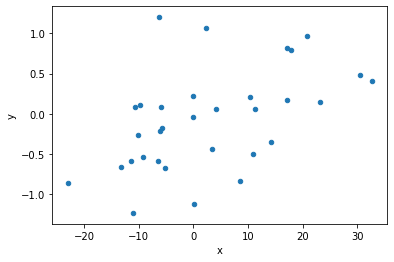

In [100]:
pd.DataFrame({'x': points_gdf_sorted.loc[points_gdf_sorted.id==1056,contours_gdf.index.to_list()].values[0],
              'y': climate_df['IPO'].values}).plot.scatter(x='x', y='y')

In [110]:
corr = climate_df.corr()
corr.style.background_gradient(cmap='RdBu')

,SOI,IOD,SAM,IPO,PDO
SOI,1,-0.149045,0.257043,-0.934444,-0.660468
IOD,-0.149045,1,0.0852707,0.124374,-0.137683
SAM,0.257043,0.0852707,1,-0.222815,-0.0916079
IPO,-0.934444,0.124374,-0.222815,1,0.792527
PDO,-0.660468,-0.137683,-0.0916079,0.792527,1


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)